In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [3]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [4]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [5]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [6]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [7]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [9]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

<h1> CNN1 - BiGRU1 </h1>


In [10]:
from tensorflow.keras.layers import GRU
model = Sequential()
# CNN layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
# Dropout layer
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 126, 64)           1792      
                                                                 
 dropout (Dropout)           (None, 126, 64)           0         
                                                                 
 bidirectional (Bidirection  (None, 256)               148992    
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                        

In [11]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 20s 66ms/step - loss: 1.0396 - accuracy: 0.5732 - val_loss: 0.5164 - val_accuracy: 0.7597
Epoch 2/10
58/58 [==============================] - 2s 26ms/step - loss: 0.4740 - accuracy: 0.7973 - val_loss: 0.3870 - val_accuracy: 0.8400
Epoch 3/10
58/58 [==============================] - 2s 30ms/step - loss: 0.3314 - accuracy: 0.8683 - val_loss: 0.2501 - val_accuracy: 0.8985
Epoch 4/10
58/58 [==============================] - 1s 17ms/step - loss: 0.2430 - accuracy: 0.9090 - val_loss: 0.1936 - val_accuracy: 0.9229
Epoch 5/10
58/58 [==============================] - 1s 17ms/step - loss: 0.2119 - accuracy: 0.9204 - val_loss: 0.2020 - val_accuracy: 0.9152
Epoch 6/10
58/58 [==============================] - 1s 18ms/step - loss: 0.1870 - accuracy: 0.9255 - val_loss: 0.1567 - val_accuracy: 0.9406
Epoch 7/10
58/58 [==============================] - 1s 19ms/step - loss: 0.1474 - accuracy: 0.9414 - val_loss: 0.1409 - val_accuracy: 0.9429
Epoch 8/10
5

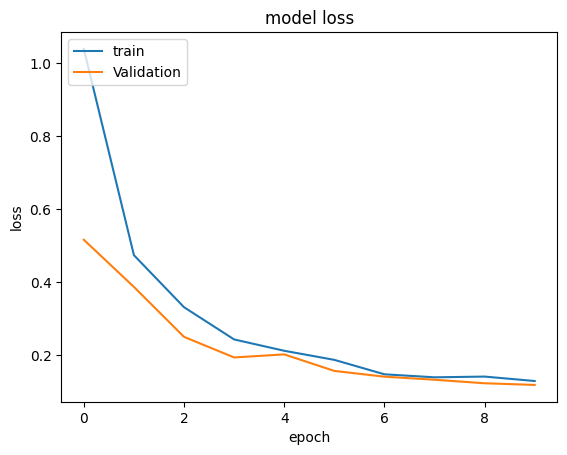

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

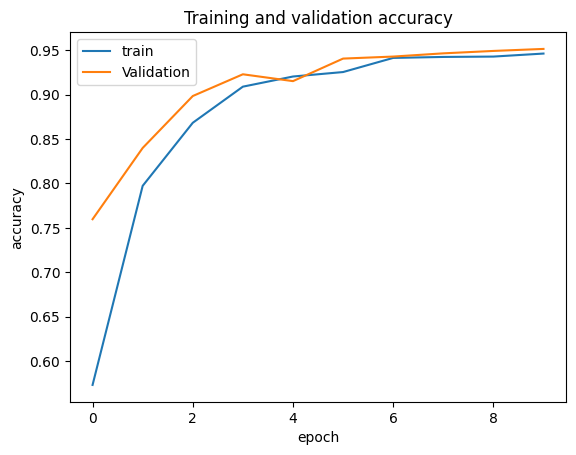

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 2s 9ms/step
[[472  10  14   0   0   0]
 [  4 437  30   0   0   0]
 [  7   1 412   0   0   0]
 [  0  23   1 356 111   0]
 [  2   4   0  69 457   0]
 [  0   0   0   0   0 537]]
0.9063454360366474
0.9052450240365769
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       496
           1       0.92      0.93      0.92       471
           2       0.90      0.98      0.94       420
           3       0.84      0.73      0.78       491
           4       0.80      0.86      0.83       532
           5       1.00      1.00      1.00       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



<Axes: >

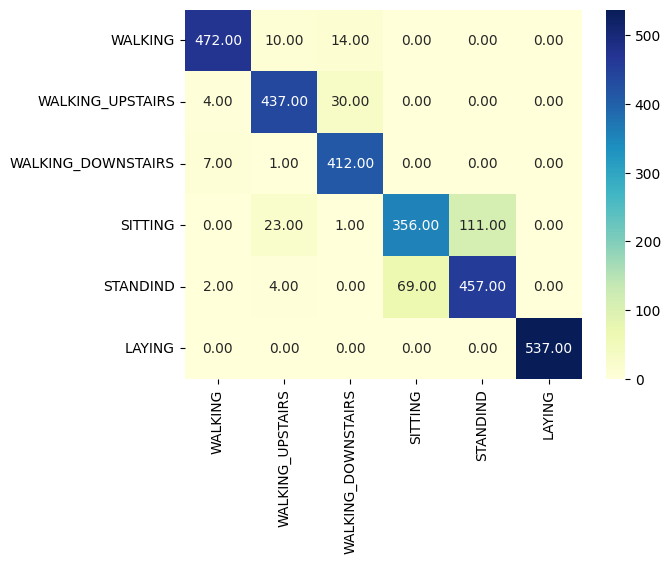

In [14]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1> CNN2 - BiGRU1 </h1>

In [15]:
from tensorflow.keras.layers import GRU
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 dropout_2 (Dropout)         (None, 126, 64)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 124, 64)           12352     
                                                                 
 dropout_3 (Dropout)         (None, 124, 64)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               148992    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                      

In [16]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 11s 46ms/step - loss: 1.0771 - accuracy: 0.5510 - val_loss: 0.6123 - val_accuracy: 0.7280
Epoch 2/10
58/58 [==============================] - 1s 21ms/step - loss: 0.5331 - accuracy: 0.7707 - val_loss: 0.5665 - val_accuracy: 0.7502
Epoch 3/10
58/58 [==============================] - 1s 22ms/step - loss: 0.3591 - accuracy: 0.8524 - val_loss: 0.2905 - val_accuracy: 0.8849
Epoch 4/10
58/58 [==============================] - 1s 22ms/step - loss: 0.2493 - accuracy: 0.9051 - val_loss: 0.2228 - val_accuracy: 0.9166
Epoch 5/10
58/58 [==============================] - 1s 24ms/step - loss: 0.1882 - accuracy: 0.9291 - val_loss: 0.1774 - val_accuracy: 0.9397
Epoch 6/10
58/58 [==============================] - 1s 21ms/step - loss: 0.1715 - accuracy: 0.9331 - val_loss: 0.1576 - val_accuracy: 0.9470
Epoch 7/10
58/58 [==============================] - 1s 23ms/step - loss: 0.1595 - accuracy: 0.9385 - val_loss: 0.1868 - val_accuracy: 0.9211
Epoch 8/10
5

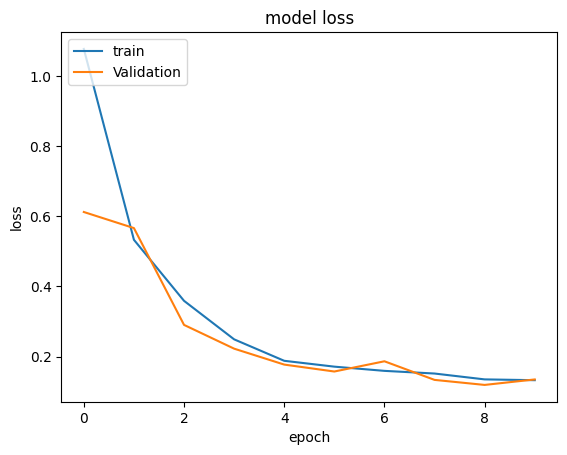

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

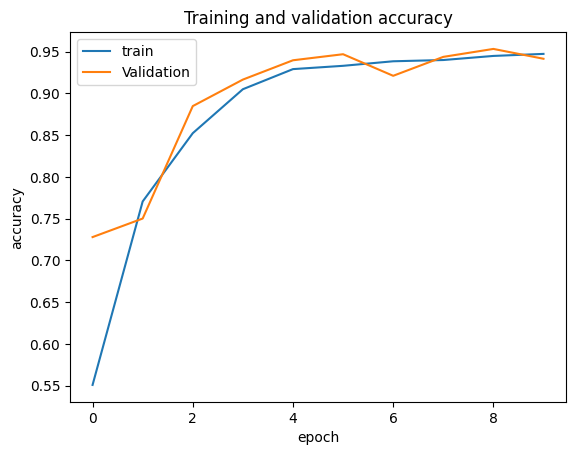

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 2s 7ms/step
[[483  12   1   0   0   0]
 [ 15 433  22   0   1   0]
 [ 26   3 391   0   0   0]
 [  0   7   0 322 162   0]
 [  0   0   0  43 489   0]
 [  0  17  10   0   0 510]]
0.8917543264336614
0.890199243625492
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       496
           1       0.92      0.92      0.92       471
           2       0.92      0.93      0.93       420
           3       0.88      0.66      0.75       491
           4       0.75      0.92      0.83       532
           5       1.00      0.95      0.97       537

    accuracy                           0.89      2947
   macro avg       0.90      0.89      0.89      2947
weighted avg       0.90      0.89      0.89      2947



<Axes: >

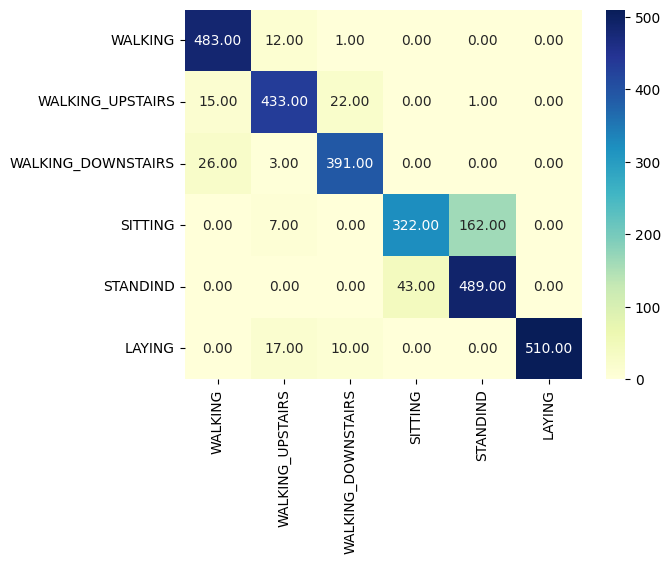

In [19]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>CNN1 - BiGRU2 </h1>

In [25]:
from tensorflow.keras.layers import GRU
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences=True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 dropout_14 (Dropout)        (None, 126, 64)           0         
                                                                 
 bidirectional_12 (Bidirect  (None, 126, 256)          148992    
 ional)                                                          
                                                                 
 dropout_15 (Dropout)        (None, 126, 256)          0         
                                                                 
 bidirectional_13 (Bidirect  (None, 256)               296448    
 ional)                                                          
                                                                 
 dropout_16 (Dropout)        (None, 256)              

In [26]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 19s 107ms/step - loss: 0.9611 - accuracy: 0.5924 - val_loss: 0.5055 - val_accuracy: 0.7779
Epoch 2/10
58/58 [==============================] - 2s 40ms/step - loss: 0.4703 - accuracy: 0.7998 - val_loss: 0.4181 - val_accuracy: 0.8409
Epoch 3/10
58/58 [==============================] - 2s 41ms/step - loss: 0.3192 - accuracy: 0.8788 - val_loss: 0.3241 - val_accuracy: 0.8658
Epoch 4/10
58/58 [==============================] - 2s 40ms/step - loss: 0.2179 - accuracy: 0.9174 - val_loss: 0.1453 - val_accuracy: 0.9374
Epoch 5/10
58/58 [==============================] - 2s 41ms/step - loss: 0.1912 - accuracy: 0.9252 - val_loss: 0.1415 - val_accuracy: 0.9479
Epoch 6/10
58/58 [==============================] - 3s 55ms/step - loss: 0.1413 - accuracy: 0.9440 - val_loss: 0.1195 - val_accuracy: 0.9551
Epoch 7/10
58/58 [==============================] - 2s 41ms/step - loss: 0.1324 - accuracy: 0.9478 - val_loss: 0.1150 - val_accuracy: 0.9497
Epoch 8/10


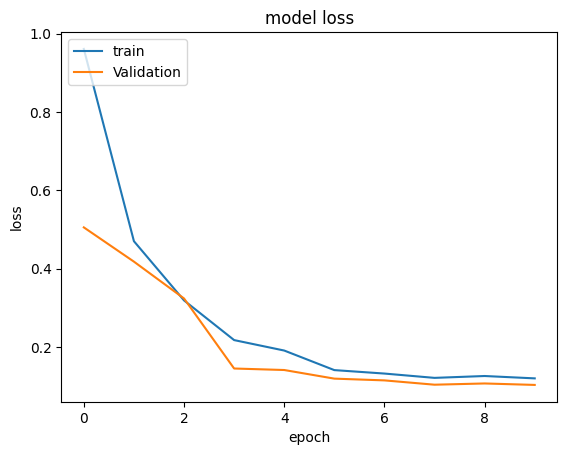

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

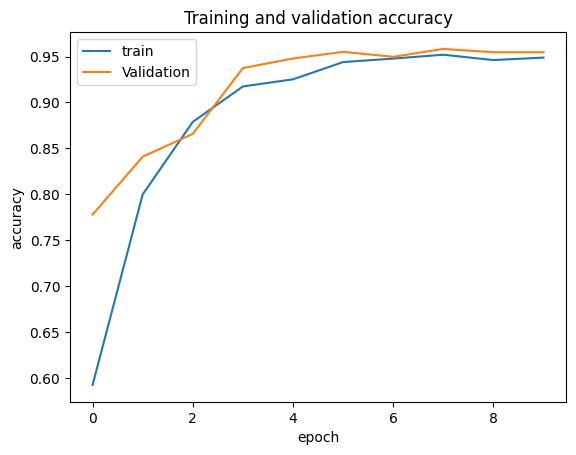

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 3s 9ms/step
[[475  18   3   0   0   0]
 [  6 446  19   0   0   0]
 [  3  11 406   0   0   0]
 [  0  25   0 423  43   0]
 [  0   4   0 112 416   0]
 [  0  27   0   0   0 510]]
0.9080420766881574
0.9083592998844031
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       496
           1       0.84      0.95      0.89       471
           2       0.95      0.97      0.96       420
           3       0.79      0.86      0.82       491
           4       0.91      0.78      0.84       532
           5       1.00      0.95      0.97       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



<Axes: >

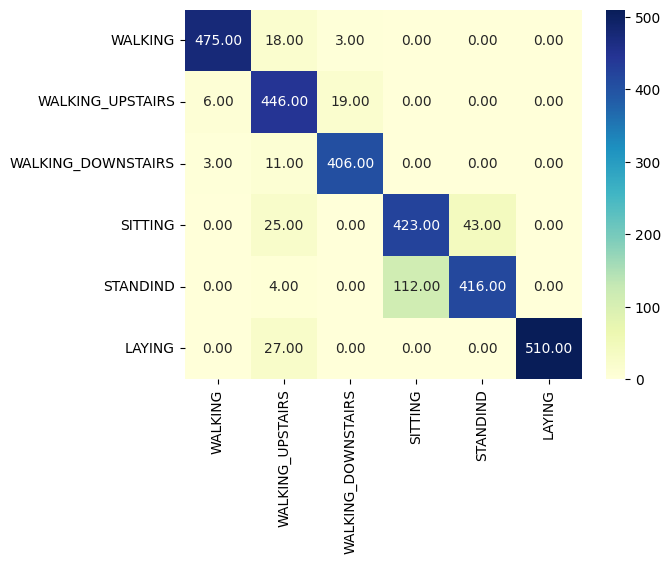

In [29]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>CNN 2 - BiGRU2 </h1>

In [30]:
from tensorflow.keras.layers import GRU
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences=True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 dropout_17 (Dropout)        (None, 126, 64)           0         
                                                                 
 conv1d_10 (Conv1D)          (None, 124, 64)           12352     
                                                                 
 dropout_18 (Dropout)        (None, 124, 64)           0         
                                                                 
 bidirectional_14 (Bidirect  (None, 124, 256)          148992    
 ional)                                                          
                                                                 
 dropout_19 (Dropout)        (None, 124, 256)          0         
                                                      

In [31]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 19s 106ms/step - loss: 0.9788 - accuracy: 0.5666 - val_loss: 0.6350 - val_accuracy: 0.6963
Epoch 2/10
58/58 [==============================] - 3s 52ms/step - loss: 0.4221 - accuracy: 0.8229 - val_loss: 0.3554 - val_accuracy: 0.8713
Epoch 3/10
58/58 [==============================] - 3s 50ms/step - loss: 0.2793 - accuracy: 0.8946 - val_loss: 0.2412 - val_accuracy: 0.9039
Epoch 4/10
58/58 [==============================] - 3s 44ms/step - loss: 0.1991 - accuracy: 0.9249 - val_loss: 0.2138 - val_accuracy: 0.9207
Epoch 5/10
58/58 [==============================] - 3s 50ms/step - loss: 0.1544 - accuracy: 0.9391 - val_loss: 0.1409 - val_accuracy: 0.9383
Epoch 6/10
58/58 [==============================] - 2s 42ms/step - loss: 0.1443 - accuracy: 0.9437 - val_loss: 0.1342 - val_accuracy: 0.9383
Epoch 7/10
58/58 [==============================] - 2s 41ms/step - loss: 0.1356 - accuracy: 0.9452 - val_loss: 0.1465 - val_accuracy: 0.9406
Epoch 8/10


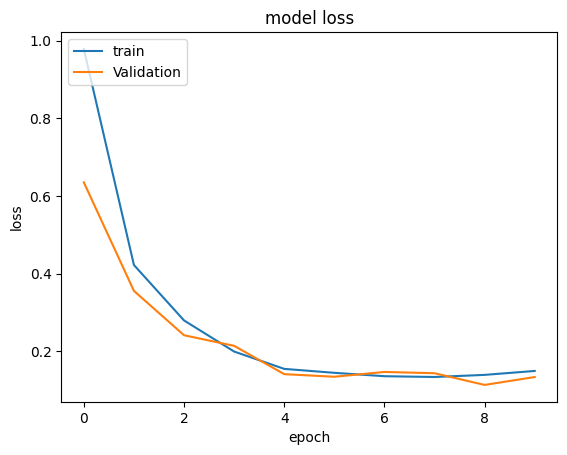

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

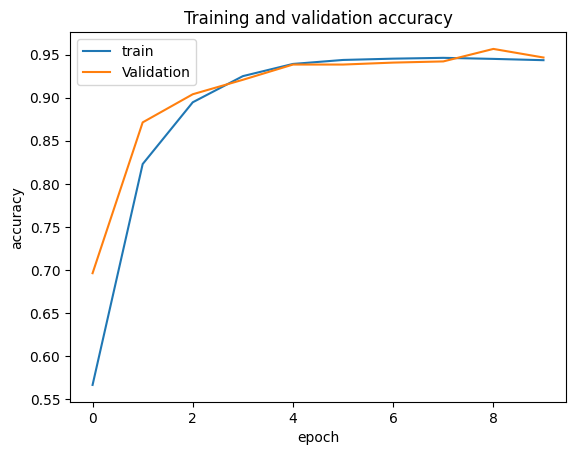

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 5s 12ms/step
[[451   7   0   0  38   0]
 [ 32 431   0   0   8   0]
 [ 38   6 376   0   0   0]
 [  0  24   0 369  98   0]
 [  0   0   0  78 454   0]
 [  0  27   0   0   0 510]]
0.8791991856124872
0.8801946158145009
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       496
           1       0.87      0.92      0.89       471
           2       1.00      0.90      0.94       420
           3       0.83      0.75      0.79       491
           4       0.76      0.85      0.80       532
           5       1.00      0.95      0.97       537

    accuracy                           0.88      2947
   macro avg       0.89      0.88      0.88      2947
weighted avg       0.88      0.88      0.88      2947



<Axes: >

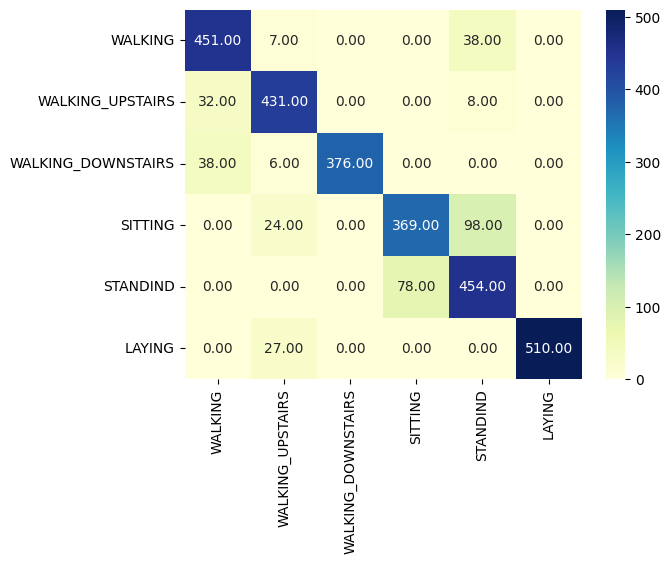

In [34]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>CNN 2 - BiGRU2 (Crossed) </h1>

In [36]:
from tensorflow.keras.layers import GRU
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences=True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)          (None, 126, 64)           1792      
                                                                 
 dropout_25 (Dropout)        (None, 126, 64)           0         
                                                                 
 bidirectional_18 (Bidirect  (None, 126, 256)          148992    
 ional)                                                          
                                                                 
 dropout_26 (Dropout)        (None, 126, 256)          0         
                                                                 
 conv1d_14 (Conv1D)          (None, 124, 64)           49216     
                                                                 
 dropout_27 (Dropout)        (None, 124, 64)           0         
                                                     

In [37]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 21s 131ms/step - loss: 1.0103 - accuracy: 0.5437 - val_loss: 0.6051 - val_accuracy: 0.6981
Epoch 2/10
58/58 [==============================] - 2s 40ms/step - loss: 0.5388 - accuracy: 0.7504 - val_loss: 0.3552 - val_accuracy: 0.8608
Epoch 3/10
58/58 [==============================] - 2s 38ms/step - loss: 0.3251 - accuracy: 0.8743 - val_loss: 0.2524 - val_accuracy: 0.8917
Epoch 4/10
58/58 [==============================] - 2s 38ms/step - loss: 0.2337 - accuracy: 0.9112 - val_loss: 0.1586 - val_accuracy: 0.9402
Epoch 5/10
58/58 [==============================] - 2s 38ms/step - loss: 0.1585 - accuracy: 0.9346 - val_loss: 0.1824 - val_accuracy: 0.9225
Epoch 6/10
58/58 [==============================] - 2s 40ms/step - loss: 0.1629 - accuracy: 0.9344 - val_loss: 0.1202 - val_accuracy: 0.9519
Epoch 7/10
58/58 [==============================] - 3s 44ms/step - loss: 0.1380 - accuracy: 0.9433 - val_loss: 0.1256 - val_accuracy: 0.9465
Epoch 8/10


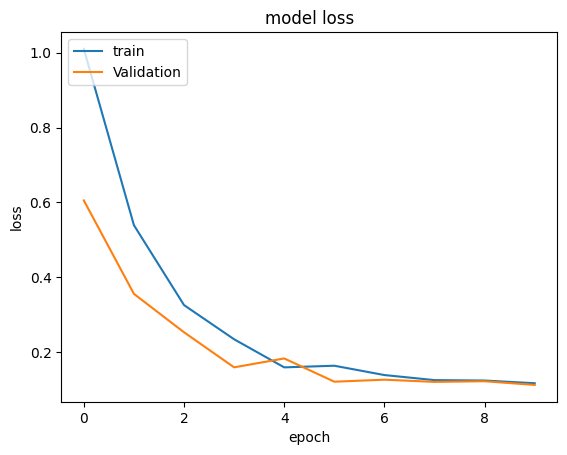

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

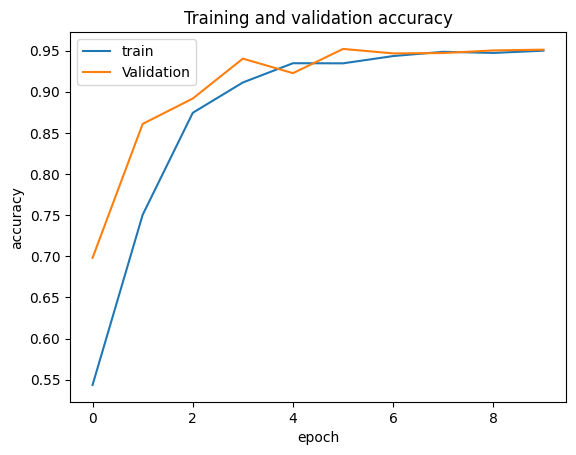

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 2s 9ms/step
[[457   4  35   0   0   0]
 [  3 436  32   0   0   0]
 [  0   1 419   0   0   0]
 [  2  23   0 375  91   0]
 [  2   0   0 100 430   0]
 [  0  27   0   0   0 510]]
0.8914149983033594
0.8912455635814746
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       496
           1       0.89      0.93      0.91       471
           2       0.86      1.00      0.92       420
           3       0.79      0.76      0.78       491
           4       0.83      0.81      0.82       532
           5       1.00      0.95      0.97       537

    accuracy                           0.89      2947
   macro avg       0.89      0.89      0.89      2947
weighted avg       0.89      0.89      0.89      2947



<Axes: >

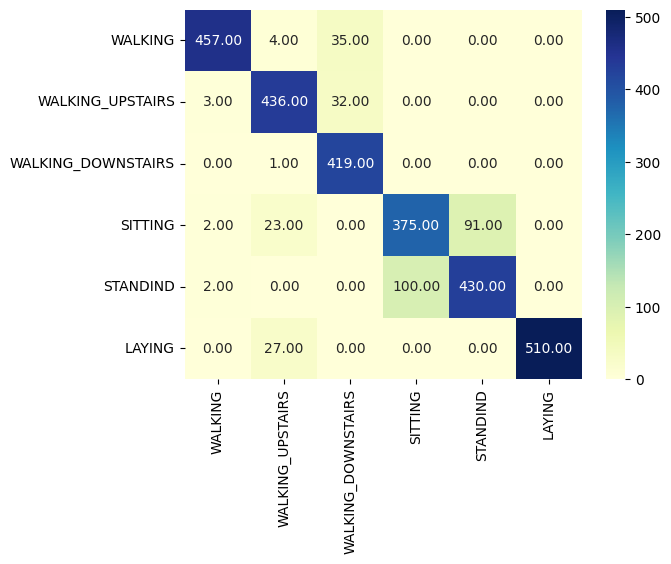

In [40]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>CNN 3 - BiGRU 3 </h1>

In [41]:
from tensorflow.keras.layers import GRU
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences=True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences=True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 126, 64)           1792      
                                                                 
 dropout_29 (Dropout)        (None, 126, 64)           0         
                                                                 
 conv1d_16 (Conv1D)          (None, 124, 64)           12352     
                                                                 
 dropout_30 (Dropout)        (None, 124, 64)           0         
                                                                 
 conv1d_17 (Conv1D)          (None, 122, 64)           12352     
                                                                 
 dropout_31 (Dropout)        (None, 122, 64)           0         
                                                                 
 bidirectional_20 (Bidirect  (None, 122, 256)        

In [42]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 29s 96ms/step - loss: 1.0647 - accuracy: 0.5475 - val_loss: 0.8068 - val_accuracy: 0.6940
Epoch 2/10
58/58 [==============================] - 4s 63ms/step - loss: 0.4999 - accuracy: 0.7851 - val_loss: 0.9460 - val_accuracy: 0.7185
Epoch 3/10
58/58 [==============================] - 4s 65ms/step - loss: 0.3589 - accuracy: 0.8550 - val_loss: 0.5264 - val_accuracy: 0.8205
Epoch 4/10
58/58 [==============================] - 4s 65ms/step - loss: 0.2401 - accuracy: 0.9095 - val_loss: 0.2852 - val_accuracy: 0.9025
Epoch 5/10
58/58 [==============================] - 4s 65ms/step - loss: 0.1836 - accuracy: 0.9321 - val_loss: 0.2248 - val_accuracy: 0.9157
Epoch 6/10
58/58 [==============================] - 4s 61ms/step - loss: 0.1633 - accuracy: 0.9374 - val_loss: 0.1555 - val_accuracy: 0.9365
Epoch 7/10
58/58 [==============================] - 3s 60ms/step - loss: 0.1530 - accuracy: 0.9395 - val_loss: 0.1694 - val_accuracy: 0.9320
Epoch 8/10
5

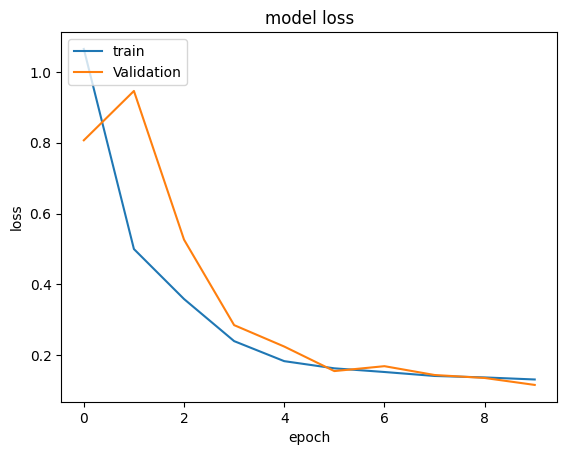

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

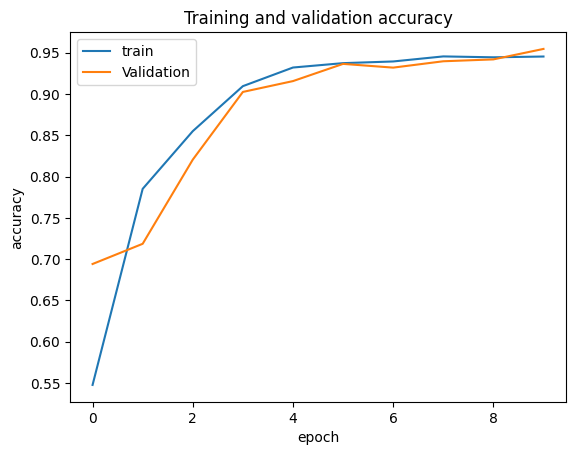

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 3s 13ms/step
[[460  22  12   0   2   0]
 [  4 423  44   0   0   0]
 [  1  10 409   0   0   0]
 [  0  19   4 379  88   1]
 [  0   0   0  88 444   0]
 [  0  22   5   0   0 510]]
0.8907363420427553
0.89091026787381
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       496
           1       0.85      0.90      0.87       471
           2       0.86      0.97      0.91       420
           3       0.81      0.77      0.79       491
           4       0.83      0.83      0.83       532
           5       1.00      0.95      0.97       537

    accuracy                           0.89      2947
   macro avg       0.89      0.89      0.89      2947
weighted avg       0.89      0.89      0.89      2947



<Axes: >

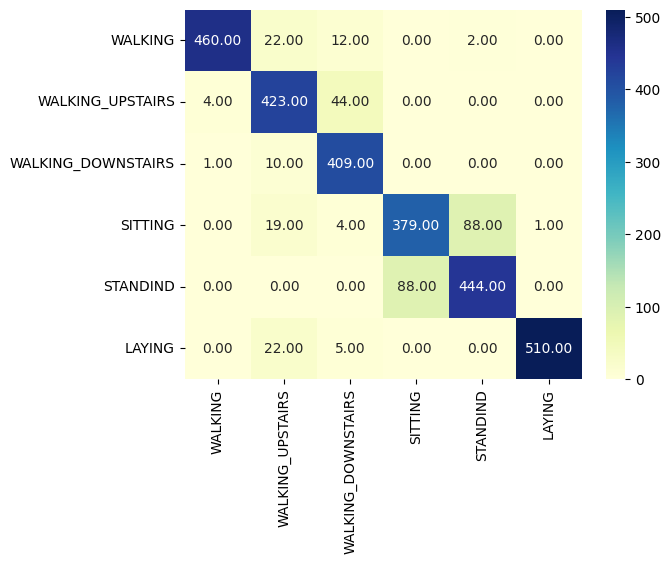

In [45]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')